# Loading Data and Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from gensim import corpora
from gensim import models
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
df_train = pd.read_csv('training_set.csv',
                       encoding = 'latin-1',
                       parse_dates = ['Created']).sort_values(['Created'], ascending = [1]).set_index('Created', drop = False)

df_hold = pd.read_csv('holdout_set.csv',
                      encoding = 'latin-1',
                      parse_dates = ['Created']).sort_values(['Created'], ascending = [1]).set_index('Created', drop = False)

C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)
C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\dateutil\parser\_parser.py:1204: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


In [3]:
X = df_train.drop('Engagements', axis = 1)
Y = df_train['Engagements']

# Creating Features

## Time Series - Month Seasonality with Trend

In [4]:
#doing this to be able to put this into linear regression
X['month'] = X.Created.apply(lambda x: x.month) #seasonal term
X['year_month'] = X.Created.apply(lambda x: x.month + x.year * 12) #trend term

#defining pipeline
time_series_pipe = make_pipeline( OneHotEncoder(categorical_features=[0], sparse=False),
                                  PolynomialFeatures(include_bias=False),
                                  LinearRegression())

C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


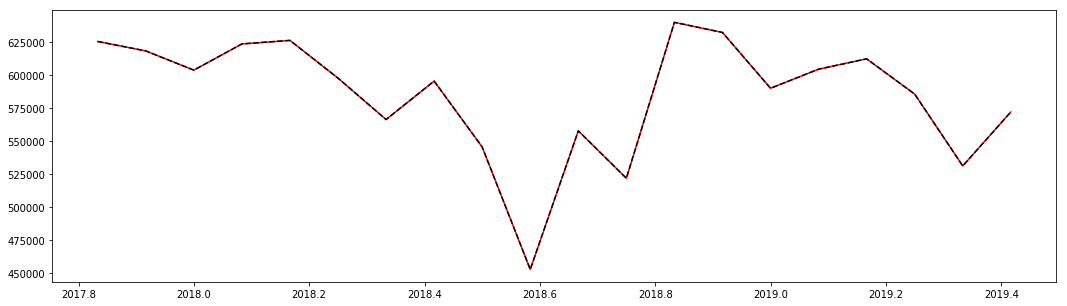

In [5]:
#plot appears pretty much perfect:

#plotting to see if it works:
time_series_pipe.fit(X[['month', 'year_month']], Y)

plt.figure(figsize =(18, 5))
plt.plot(X['year_month']/12, time_series_pipe.predict(X[['month', 'year_month']]), 'r')
plt.plot((X['year_month']/12).unique(), Y.resample('M').mean(), 'k--')

## Time Series - Hourly with day of Week and Trend

In [6]:
#doing this to be able to put this into linear regression
X['hour'] = X.Created.apply(lambda x: x.hour) #seasonal term
X['weekend'] = X.Created.apply(lambda x: int(x.dayofweek >= 5)) #seasonal term
X['weekend_hour_interaction'] = X.Created.apply(lambda x: int(x.dayofweek >= 5) * x.hour) #seasonal term
X['weekday_hour_interaction'] = X.Created.apply(lambda x: int(x.dayofweek < 5) * x.hour) #seasonal term

In [7]:
#defining pipeline
time_series_pipe2 = make_pipeline( OneHotEncoder(categorical_features=[0, 1, 2, 3], sparse=False),
                                  PolynomialFeatures(include_bias=False),
                                  LinearRegression())

#plotting to see if it works:
time_series_pipe2.fit(X[['hour', 'weekend', 'weekend_hour_interaction', 'weekday_hour_interaction', 'year_month']], Y)

C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\_encoders.py:390: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Pipeline(memory=None,
     steps=[('onehotencoder', OneHotEncoder(categorical_features=[0, 1, 2, 3], categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)), ('polynomialfeatures', PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)), ('linearregression', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

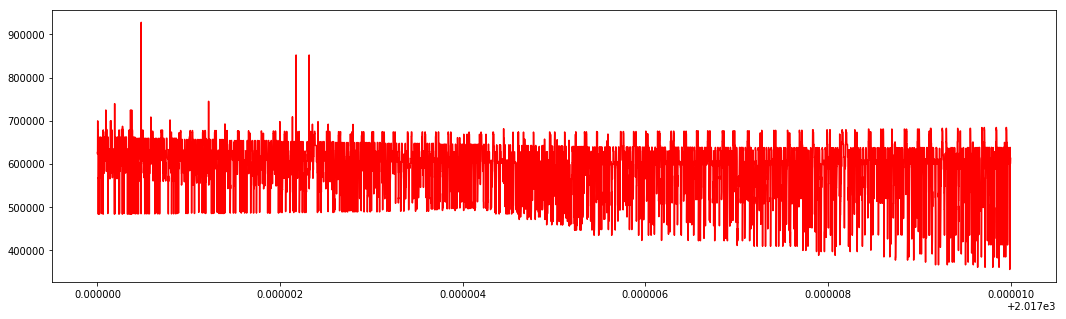

In [8]:
plt.figure(figsize =(18, 5))
plt.plot(np.linspace(2017, 2017.00001, 7766),
         time_series_pipe2.predict(X[['hour', 'weekend', 'weekend_hour_interaction', 'weekday_hour_interaction', 'year_month']]), 'r')

## Getting Features from text:

In [9]:
#copied from AML, feel free to add your AML stuff

X['containsLink'] = X.Description.str.contains('.http').astype(float)
X['exclamationPointCount'] =X.Description.str.count('!').astype(float)
X['questionMarkCount'] = X.Description.str.count('\?').astype(float)
X['doubleQuotationMarkCount'] = X.Description.str.count('\"').astype(float)
X['singleQuoteMarkCount'] = X.Description.str.count('\'').astype(float)
X['commaMarkCount'] = X.Description.str.count(',').astype(float)
X['collinCount'] = X.Description.str.count(':').astype(float)
X['semiCollinCount'] = X.Description.str.count(';').astype(float)
X['percentMarkCount'] = X.Description.str.count('%').astype(float)
X['dollarSignCount'] = X.Description.str.count('$').astype(float)
X['hashCount'] = X.Description.str.count('#').astype(float)
X['starCount'] = X.Description.str.count('\*').astype(float)
X['atCount'] = X.Description.str.count('@').astype(float)
X['percentCapital'] = X.Description.str.findall(r'[A-Z]').str.len().fillna(0)/X.Description.str.len().fillna(1)
X['percentlowercase'] = X.Description.str.findall(r'[a-z]').str.len().fillna(0)/X.Description.str.len().fillna(1)
X['percentnumbers'] = X.Description.str.findall(r'[0-9]').str.len().fillna(0)/X.Description.str.len().fillna(1)
X['percentother'] = 1 - X['percentCapital'] - X['percentlowercase'] - X['percentnumbers']

In [1]:
#loading data from Google

#perhaps use one better for twitter data
w = models.KeyedVectors.load_word2vec_format(
    'GoogleNews-vectors-negative300.bin.gz', binary=True)

C:\Users\tjbli\Anaconda2\envs\py36\lib\site-packages\smart_open\ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


MemoryError: 

In [ ]:
texts_train = [[token for token in doc.translate(str.maketrans('', '', string.punctuation)).lower().split()]
               for doc in X['descripion']]

texts_final_train = []

for i in range(len(texts_train)):
    doc_final = []
    for j in range(len(texts_train[i])):
            if texts_train[i][j] in w:
                doc_final.append(texts_train[i][j])    
    if len(doc_final) < 1:
        y_train_temp.pop(i)
    else:
        texts_final_train.append(doc_final)
        
X['mean_embedding'] = np.vstack([np.mean(w[doc], axis=0) for doc in texts_final_train])

In [ ]:
#need to work on this:

vect = CountVectorizer()